In [212]:
#from google.colab import drive
#drive.mount('/content/drive')

In [213]:
tmax = 10
dt = 0.01

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np

class FHNDataLoader(Dataset):
    def __init__(self, num_samples, t_max=100, dt=0.01):
        """
        Initialize the dataset by generating data based on the FHN model.

        Args:
            num_samples (int): Number of samples to generate.
            t_max (float): Maximum time for the simulation.
            dt (float): Time step for the Euler solver.
        """
        self.num_samples = num_samples
        self.t_max = t_max
        self.dt = dt
        np.random.seed(42)

        # Generate the training data during initialization
        training_data = self.generate_fhn_data(num_samples)
        self.inputs, self.outputs = self.prepare_data_for_loader(training_data)

    def fhn_equations(self, U, W, K):
        """FitzHugh-Nagumo equations."""
        dU_dt = K * U * (U - 0.4) * (1 - U) - W
        dW_dt = 0.5 * (0.2 * U - 0.8 * W)
        return dU_dt, dW_dt

    def euler_solver(self, u0, w0, K, t_max, dt):
        """Solve FHN model using Euler's method."""
        t = np.arange(0, t_max, dt)
        u = np.zeros_like(t)
        w = np.zeros_like(t)
        u[0], w[0] = u0, w0
        for i in range(1, len(t)):
            du_dt, dw_dt = self.fhn_equations(u[i - 1], w[i - 1], K)
            u[i] = u[i - 1] + du_dt * dt
            w[i] = w[i - 1] + dw_dt * dt
        return t, u, w

    def generate_fhn_data(self, num_samples):
        """Generate data for different initial conditions and K values."""
        data = []
        for i in range(num_samples):
            u0 = np.random.uniform(0.5, 0.6)  # Vary U0
            w0 = np.random.uniform(0, 0.1)    # Vary W0
            K = np.random.uniform(2, 2.5)     # Vary K
            t, u, w = self.euler_solver(u0, w0, K, self.t_max, self.dt)
            data.append({'u0': u0, 'w0': w0, 'K': K, 'u': u, 'w': w})
        return data

    def prepare_data_for_loader(self, training_data):
        """Prepare the dataset for the DataLoader for the MLP model."""
        inputs = []
        outputs = []

        for sample in training_data:
            u0 = sample['u0']
            w0 = sample['w0']
            K = sample['K']
            u_seq = sample['u']
            w_seq = sample['w']

            # Input: [U0, W0, K]
            inputs.append([u0, w0, K])

            # Output: [U, W]
            outputs.append([u_seq, w_seq])

        inputs = np.array(inputs)
        outputs = np.array(outputs)
        # Convert lists to tensors
        inputs_tensor = torch.tensor(inputs, dtype=torch.float32)
        outputs_tensor = torch.tensor(outputs, dtype=torch.float32)

        return inputs_tensor, outputs_tensor

    def __len__(self):
        """Return the total number of samples in the dataset."""
        return len(self.inputs)

    def __getitem__(self, idx):
        """
        Retrieve the input-output pair at the specified index.

        Args:
            idx (int): Index of the data point.

        Returns:
            tuple: (input, output) where input is [U0, W0, K, t] and output is [U, W].
        """
        return self.inputs[idx], self.outputs[idx]

# Example usage:
num_samples = 100  # Number of FHN samples to generate
batch_size = 128     # Batch size for DataLoader

# Instantiate the dataset
fhn_dataset = FHNDataLoader(num_samples=num_samples, t_max=10, dt=dt)

# Calculate the sizes for the train and validation sets
train_size = int(0.8 * len(fhn_dataset))
val_size = len(fhn_dataset) - train_size

# Split the dataset into train and validation sets
train_dataset, val_dataset = random_split(fhn_dataset, [train_size, val_size])

# Create DataLoaders for batching
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Example: Iterating over the DataLoader
for batch_idx, (input_batch, output_batch) in enumerate(train_loader):
    print(f"Training Batch {batch_idx + 1}:")
    print(f"Input: {input_batch.shape}")
    print(f"Output: {output_batch.shape}")
    break  # To only show the first batch

for batch_idx, (input_batch, output_batch) in enumerate(val_loader):
    print(f"Validation Batch {batch_idx + 1}:")
    print(f"Input: {input_batch.shape}")
    print(f"Output: {output_batch.shape}")
    break  # To only show the first batch

Training Batch 1:
Input: torch.Size([32, 3])
Output: torch.Size([32, 2, 1000])
Validation Batch 1:
Input: torch.Size([20, 3])
Output: torch.Size([20, 2, 1000])


In [215]:

import torch
import torch.nn as nn

# Check if GPU is available, else use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


class FHNMLP_LSTM_Model(nn.Module):
    def __init__(self, input_size=3, hidden_size=256, output_size=2, num_hidden_layers=10):
        super(FHNMLP_LSTM_Model, self).__init__()

        self.hidden_size = hidden_size

        self.hidden_layers = nn.ModuleList(
            [nn.Linear(hidden_size, hidden_size) for _ in range(num_hidden_layers)])


        self.input_fc = nn.Linear(input_size, hidden_size)
        self.mid_fc = nn.Linear(hidden_size, hidden_size)
        self.lstm_cell = nn.LSTMCell(hidden_size, hidden_size)
        self.output_fc = nn.Linear(hidden_size, output_size)
        self.activation = nn.Tanh()

    def forward(self, initial_state):
        """
        Forward pass through the network.

        x: Input tensor containing the parameters [U0, W0, K]
        Returns the network predictions for U and W (u_pred, w_pred)
        """
        batch_size = initial_state.size(0)
        h_t = torch.zeros(batch_size, self.hidden_size,
                          device=initial_state.device)
        c_t = torch.zeros(batch_size, self.hidden_size,
                          device=initial_state.device)
        x_t = self.input_fc(initial_state)
        outputs = []
        for t in range(int(tmax/dt)):
            h_t, c_t = self.lstm_cell(x_t, (h_t, c_t))
            # Add to outputs
            for hidden_layer in self.hidden_layers:
                h_t = self.activation(hidden_layer(h_t))
            output_t = self.output_fc(h_t) # [batch_size, 2]
            outputs.append(output_t)
            x_t = self.mid_fc(h_t)

        # shape: [batch_size, T, output_size]
        outputs = torch.stack(outputs, dim=1)
        predicted_u = outputs[:, :, 0]
        predicted_w = outputs[:, :, 1]
    
        return predicted_u, predicted_w

Using device: cuda


In [216]:
def fhn_equations(U, W, K):
    """FitzHugh-Nagumo equations."""
    dU_dt = K * U * (U - 0.4) * (1 - U) - W
    dW_dt = 0.5 * (0.2 * U - 0.8 * W)
    return dU_dt, dW_dt

In [217]:
import torch

def fhn_equations(u, w, K):
    """FitzHugh-Nagumo equations at t=0."""
    du_dt = K * u * (u - 0.4) * (1 - u) - w
    dw_dt = 0.5 * (0.2 * u - 0.8 * w)
    return du_dt, dw_dt

def initial_condition_loss(model, inputs, u0, w0):
    """
    Loss that enforces the initial condition constraint based on FHN dynamics at t=0.

    Args:
        model: The neural network model.
        inputs: Input tensor containing [u0, w0, K, t] where t should be set to 0.
        K: True initial value of the parameter K.

    Returns:
        loss: Initial condition loss that penalizes deviation from true FHN dynamics at t=0.
    """
    # Unpack initial conditions from inputs
    inputs_at_t0 = inputs.clone()
    u0, w0, K = inputs_at_t0[:, 0], inputs_at_t0[:, 1], inputs_at_t0[:, 2]


    du_dt, dw_dt = fhn_equations(u0, w0, K)
    u_0 = u0 + du_dt * dt
    w_0 = w0 + dw_dt * dt


    # Perform the forward pass through the model with t=0
    u_pred, w_pred = model(inputs_at_t0)

    # Compute the loss for initial conditions
    loss_u0 = torch.mean((u_pred[:,0] - u_0) ** 2)
    loss_w0 = torch.mean((w_pred[:,0] - w_0) ** 2)

    # Aggregate the total initial condition loss
    loss = (loss_u0 + loss_w0)/2
    return loss


In [218]:
def data_driven_loss(model, inputs, u_solver, w_solver):
    """
    Loss that enforces the data-driven constraint, comparing network predictions with the solver results.
    """
    # Perform the forward pass through the network
    u_pred, w_pred = model(inputs)

    # Compute the L2 loss between the network prediction and the solver results
    loss_u = torch.mean((u_pred - u_solver) ** 2)
    loss_w = torch.mean((w_pred - w_solver) ** 2)

    # Aggregate the total data-driven loss
    loss = (loss_u + loss_w)/2
    return loss


In [219]:
def total_loss(model, inputs, u_solver, w_solver, u0, w0, K, lambda_LD, lambda_LB):
    """
    Total loss function that combines the data-driven, physics-informed, and initial condition losses.
    """
    # Compute individual losses
    loss_LD =0
    loss_LB =0




    loss_LD = data_driven_loss(model, inputs, u_solver, w_solver)
    loss_LB = initial_condition_loss(model, inputs, u0, w0)
    # Combine the losses with the respective lambda coefficients
    loss = (lambda_LD * loss_LD + lambda_LB * loss_LB)/(lambda_LD+lambda_LB)
    return loss


In [220]:
# Instantiate the model and move it to the selected device (GPU or CPU)
# model = FHNMLPModel().to(device)
model = FHNMLP_LSTM_Model().to(device)

# Check the model architecture
print(model)

FHNMLP_LSTM_Model(
  (hidden_layers): ModuleList(
    (0-9): 10 x Linear(in_features=256, out_features=256, bias=True)
  )
  (input_fc): Linear(in_features=3, out_features=256, bias=True)
  (mid_fc): Linear(in_features=256, out_features=256, bias=True)
  (lstm_cell): LSTMCell(256, 256)
  (output_fc): Linear(in_features=256, out_features=2, bias=True)
  (activation): Tanh()
)


In [221]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Test model on validation set and compute the loss


def test_model_on_val(model, val_loader, criterion):
    """
    Test the model on the validation set and compute the loss.

    Args:
        model: The trained neural network model.
        val_loader: DataLoader for the validation dataset.
        criterion: Loss function to compute the error.

    Returns:
        avg_loss: The average loss for the validation set.
        predictions: List of predicted outputs from the model.
        true_values: List of true values from the validation set.
    """
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    predictions_u = []  # Separate lists for u and w predictions
    predictions_w = []
    true_values_u = []  # Separate lists for u and w true values
    true_values_w = []

    with torch.no_grad():  # Disable gradient calculation for testing
        for inputs, targets in val_loader:
            # Move inputs and targets to the GPU
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            u_pred, w_pred = model(inputs)

            # Compute the loss
            loss_u = criterion(u_pred, targets[:, 0])
            loss_w = criterion(w_pred, targets[:, 1])
            loss = loss_u + loss_w
            total_loss += loss.item()

            # Store predictions and true values for plotting
            predictions_u.append(u_pred.cpu().numpy())
            true_values_u.append(targets[:, 0].cpu().numpy())
            predictions_w.append(w_pred.cpu().numpy())
            true_values_w.append(targets[:, 1].cpu().numpy())

    avg_loss = total_loss / len(val_loader)

    # Concatenate separately for u and w
    predictions_u = np.concatenate(predictions_u, axis=0)
    predictions_w = np.concatenate(predictions_w, axis=0)
    true_values_u = np.concatenate(true_values_u, axis=0)
    true_values_w = np.concatenate(true_values_w, axis=0)

    return avg_loss, [predictions_u, predictions_w], [true_values_u, true_values_w]

In [ ]:
# Example of setting up loss function and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 10
lambda_LD = 1 # Adjust the weight for the data-driven loss
lambda_LI = 1 # Adjust the weight for the physics-informed loss
lambda_LB = 1 # Adjust the weight for the initial condition loss

training_losses = []
validation_losses = []
for epoch in range(num_epochs):
    model.train()  # Ensure the model is in training mode
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move inputs and targets to the GPU
        inputs, targets = inputs.to(device), targets.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Extract necessary values
        u_solver, w_solver = targets[:, 0], targets[:, 1]  # Assuming solver data is in targets
        u0, w0, K= inputs[:, 0], inputs[:, 1], inputs[:, 2]

        # Compute the total loss (LT)
        loss = total_loss(model, inputs, u_solver, w_solver, u0, w0, K, lambda_LD, lambda_LB)
        # Backward pass: Compute gradients and update weights
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
    training_losses.append(loss.item())
    # Run validation
    criterion = torch.nn.MSELoss()
    avg_loss, predictions, true_values = test_model_on_val(
        model, val_loader, criterion)
    validation_losses.append(avg_loss)
    print(f"Average Validation Loss: {avg_loss:.4f}")


Epoch [1/50], Loss: 0.0223
Average Validation Loss: 0.3517
Epoch [2/50], Loss: 0.0259
Average Validation Loss: 0.0880
Epoch [3/50], Loss: 0.0466
Average Validation Loss: 0.0988
Epoch [4/50], Loss: 0.0301
Average Validation Loss: 0.0695
Epoch [5/50], Loss: 0.0262
Average Validation Loss: 0.0858
Epoch [6/50], Loss: 0.0303
Average Validation Loss: 0.0729
Epoch [7/50], Loss: 0.0198
Average Validation Loss: 0.0680
Epoch [8/50], Loss: 0.0237
Average Validation Loss: 0.0716
Epoch [9/50], Loss: 0.0220
Average Validation Loss: 0.0733
Epoch [10/50], Loss: 0.0196
Average Validation Loss: 0.0672
Epoch [11/50], Loss: 0.0274
Average Validation Loss: 0.0690
Epoch [12/50], Loss: 0.0237
Average Validation Loss: 0.0678
Epoch [13/50], Loss: 0.0215
Average Validation Loss: 0.0716
Epoch [14/50], Loss: 0.0205
Average Validation Loss: 0.0703
Epoch [15/50], Loss: 0.0207
Average Validation Loss: 0.0682
Epoch [16/50], Loss: 0.0206
Average Validation Loss: 0.0674
Epoch [17/50], Loss: 0.0204
Average Validation Lo

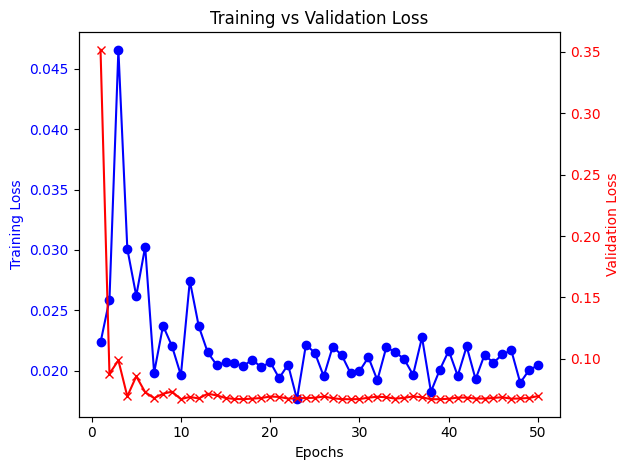

In [223]:
# Plot the training and validation losses
fig, ax1 = plt.subplots()

epochs = range(1, num_epochs + 1)
# Plot training loss
ax1.plot(epochs, training_losses, label='Training Loss',
         color='blue', marker='o')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training Loss', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a twin y-axis for validation loss
ax2 = ax1.twinx()
ax2.plot(epochs, validation_losses,
         label='Validation Loss', color='red', marker='x')
ax2.set_ylabel('Validation Loss', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add a title and legend
plt.title('Training vs Validation Loss')
fig.tight_layout()  # Adjust layout to prevent overlapping

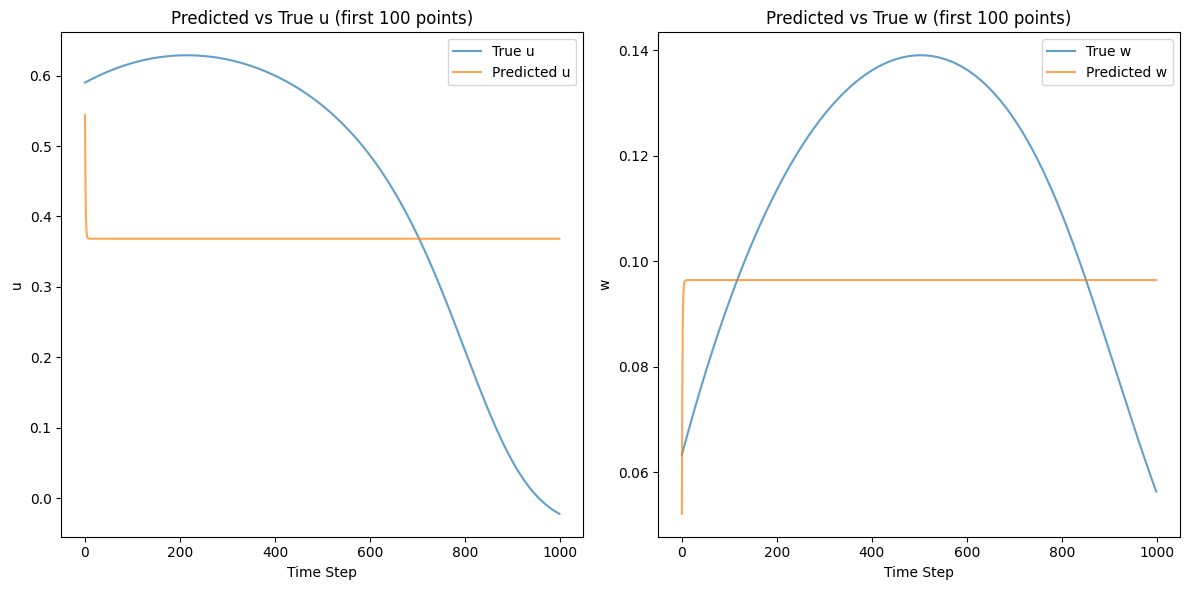

In [224]:
def plot_predictions(predictions, true_values, num_points=1000):
    """
    Plot a subset of predictions and true values for u and w.

    Args:
        predictions: List of predicted outputs from the model.
        true_values: List of true values from the validation set.
        num_points: Number of points to display in the plot (default is 100).
    """
    predictions_u, predictions_w = predictions  # Unpack predictions
    true_values_u, true_values_w = true_values  # Unpack true values

    # Limit the number of points for clearer visualization
    predictions_u = predictions_u[0]
    predictions_w = predictions_w[0]
    true_values_u = true_values_u[0]
    true_values_w = true_values_w[0]

    plt.figure(figsize=(12, 6))

    # Plot for u
    plt.subplot(1, 2, 1)
    plt.plot(true_values_u, label='True u', alpha=0.7)
    plt.plot(predictions_u, label='Predicted u', alpha=0.7)
    plt.title(f"Predicted vs True u (first {num_points} points)")
    plt.xlabel("Time Step")
    plt.ylabel("u")
    plt.legend()

    # Plot for w
    plt.subplot(1, 2, 2)
    plt.plot(true_values_w, label='True w', alpha=0.7)
    plt.plot(predictions_w, label='Predicted w', alpha=0.7)
    plt.title(f"Predicted vs True w (first {num_points} points)")
    plt.xlabel("Time Step")
    plt.ylabel("w")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
# Plot only the first 100 predictions for a closer comparison
plot_predictions(predictions, true_values, num_points=100)


In [225]:
torch.save(model.state_dict(), 'fhn_lstm_model.pth')